<a href="https://colab.research.google.com/github/sumit-rk/Data_Science-ML/blob/master/Loan_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [3]:


!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv



--2020-05-15 15:19:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2020-05-15 15:19:00 (1.80 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

# Converting to date-time object

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data Visualization and Preprocessing

Let's see how many candidates paid the loans and how many didn't 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

So we can see that 260 candidates paid off the loans.

For better understanding let's plot some graphs.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


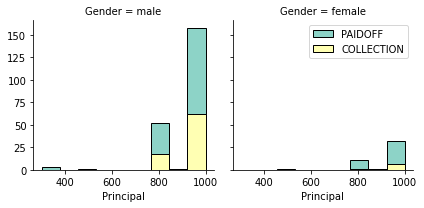

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(),df.Principal.max(),10)
g = sns.FacetGrid(df,col="Gender",hue="loan_status",palette="Set3",col_wrap=2)
g.map(plt.hist,'Principal',bins=bins,ec="k")

g.axes[1].legend()
plt.show()

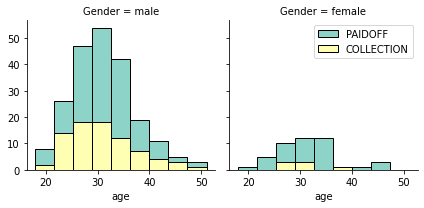

In [9]:
bins = np.linspace(df.age.min(),df.age.max(),10)

g = sns.FacetGrid(df,col="Gender",hue = "loan_status",palette="Set3",col_wrap=2)
g.map(plt.hist,'age',bins=bins,ec="k")

g.axes[1].legend()
plt.show()

# Pre-processing : Feature Selection and Extraction for model

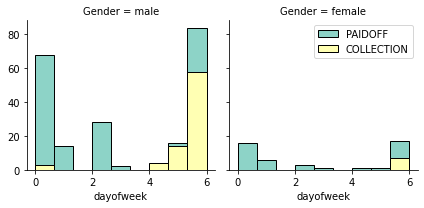

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(),df.dayofweek.max(),10)
g = sns.FacetGrid(df,col="Gender",hue="loan_status",palette="Set3",col_wrap=2)
g.map(plt.hist,'dayofweek',bins=bins,ec="k")
g.axes[-1].legend()
plt.show()

As we can observe that people who took loan at the end of week, didn't pay off.

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


**Let's look at the months of the loans**

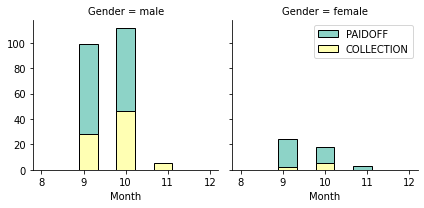

In [12]:
df['Month'] = df.due_date.dt.month
bins = np.linspace(df.Month.min()-1,df.Month.max()+1,10)
g = sns.FacetGrid(df,col="Gender",hue = "loan_status",palette ="Set3",col_wrap=2)
g.map(plt.hist,'Month',bins = bins, ec="k")
g.axes[-1].legend()
plt.show()

# Converting Categorical features to numerical values 

**GENDER**

In [0]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86% of female paid their loans and 73% of males paid their loan.

Let's do the binarization of Gender
by setting Male to 0 and Female to 1.

In [24]:
#df.Gender[df.Gender =='male'] =0
#df.Gender[df.Gender =='female']=1
df.replace(to_replace=['male','female'],value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Month,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,10,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,10,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,9,14
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,10,29
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,10,29


In [25]:
df['deadline'] = df['due_date']-df['effective_date']
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Month,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,10,29 days
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,10,29 days
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,9,14 days
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,10,29 days
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,10,29 days


In [26]:
df['deadline']=df['deadline'].dt.days
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Month,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,10,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,10,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,9,14
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,10,29
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,10,29


**EDUCATION**

In [27]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

**Features before Encoding** 

In [28]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


**Encoding the features of the data into Feature dataframe** 

In [29]:
Feature = df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])],axis=1)
Feature.drop(['Master or Above'], axis=1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


# **Feature Selection**

In [30]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


In [31]:
y =df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'],value=[0,1]).values
y[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# **Normalize Data** 

Data Standardization give data zero mean and unit variance 

In [32]:
X = preprocessing.StandardScaler().fit_transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -0.26122054,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679]])

# **Classification**

**Using K- Nearest Neighbour (kNN)**

In [0]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [0]:
X_train, y_train = X, y

In [34]:
X_train.shape, y_train.shape

((346, 9), (346,))

In [0]:
trainScores ={}

# kNN

In [55]:
from sklearn.neighbors import KNeighborsClassifier

bestScore =0.0
accList = []

for k in range(3,15):

  clf_knn = KNeighborsClassifier(n_neighbors = k, algorithm ='auto')

  scores = cross_val_score(clf_knn,X,y,cv=10)
  score = scores.mean()
  accList.append(score)

  if score > bestScore:
    bestScore = score
    best_clf = clf_knn
    bestK = k

print("Best value of K is : ",bestK," |  Cross Validation Score/ Accuracy : ",bestScore)
clf_knn = best_clf

Best value of K is :  8  |  Cross Validation Score/ Accuracy :  0.7522689075630252


In [0]:
clf_knn.fit(X_train, y_train)
y_pred = best_clf.predict(X_train) 

In [52]:
trainScores['kNN- jaccard'] = jaccard_similarity_score(y_train, y_pred)
trainScores['kNN- f1-score'] = f1_score(y_train, y_pred,average='weighted')
#trainScores['kNN- logloss'] = log_loss(y_train, y_pred)
#trainScores.drop(['kNN-logloss'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [57]:
trainScores

{'kNN- f1-score': 0.7701843558681992,
 'kNN- jaccard': 0.7947976878612717,
 'kNN- logloss': 7.08747143930668}

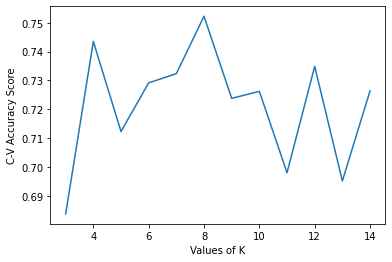

In [60]:
plt.plot(range(3,15),accList)
plt.xlabel('Values of K')
plt.ylabel('C-V Accuracy Score')
plt.show()